In [3]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [4]:
data = pd.read_csv('EURUSD.txt')

In [5]:
data.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4


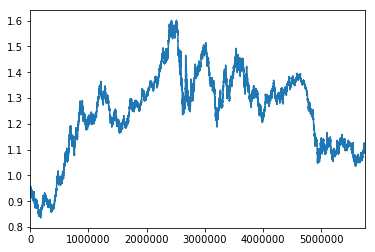

In [6]:
data_sub = data[data['<TIME>']%10000 == 0]['<OPEN>']
data_sub.plot()
plt.show()
del data

In [7]:
data_sub.shape

(96354,)

In [8]:
data_open = np.array(data_sub)
del data_sub

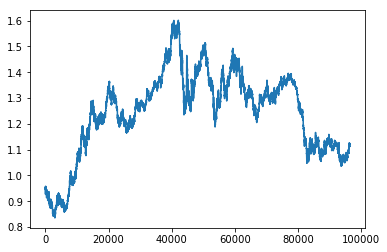

In [9]:
plt.plot(data_open)
plt.show()

In [110]:
class dnn_very_deep(object):
    def __init__(self, input_len, output_len):
        
        self.inputs = tf.placeholder(tf.float32, [None, input_len], name='input')
        self.target = tf.placeholder(tf.float32, [None, output_len], name='target')
        self.learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        self.keep_prob_rate = tf.placeholder(tf.float32, name='keep_prob')
        layer_1 = tf.layers.dense(self.inputs, 256, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_1 = tf.nn.relu(layer_1)
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob_rate)

        layer_2 = tf.layers.dense(layer_1, 256, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_2 = tf.nn.relu(layer_2)
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob_rate)

        layer_3 = tf.layers.dense(layer_2, 128, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_3 = tf.nn.relu(layer_3)
        layer_3 = tf.nn.dropout(layer_3, self.keep_prob_rate)

        layer_4 = tf.layers.dense(layer_3, 64, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        layer_4 = tf.nn.relu(layer_4)
        layer_4 = tf.nn.dropout(layer_4, self.keep_prob_rate)

        self.output_layer = tf.layers.dense(layer_4, output_len, kernel_initializer=tf.truncated_normal_initializer(stddev=0.001))
        self.cost = tf.reduce_mean((self.output_layer - self.target)**2)
        self.train_opt = tf.train.AdamOptimizer().minimize(self.cost)
    
    def data_prepare(self, data, seq_len):
        sequence_length = seq_len + 1
        result = []
        self.data_mean = data_open.mean()
        self.data_interval = data_open.max() - data_open.min()
        data_tmp = [((p - self.data_mean)/self.data_interval) for p in data_open]

        for index in range(len(data_tmp) - sequence_length):
            result.append(data_tmp[index: index + sequence_length])

        result = np.array(result)

        row = round(0.9 * result.shape[0])
        train = result[:int(row), :]
        np.random.shuffle(train)
        self.x_train = train[:, :-1]
        self.y_train = train[:, -1]
        self.x_test = result[int(row):, :-1]
        self.y_test = result[int(row):, -1]

        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1]))
        self.y_train = np.reshape(self.y_train, [-1, 1])
        self.x_test = np.reshape(self.x_test, (self.x_test.shape[0], self.x_test.shape[1]))
        self.y_test = np.reshape(self.y_test, [-1, 1])

    def train(self, batch_size=256, epochs=1, lr=0.01, keep_prob=1.0, show_every_n_batches=100):
        x_train_num = int(self.x_train.shape[0]*0.9)
        step = 0
        losses = {'train':[], 'validation':[]}
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for index in range(0, x_train_num, batch_size):
                step = step + 1
                train_loss, _ = self.sess.run([self.cost, self.train_opt], 
                                         feed_dict={
                                            self.inputs:self.x_train[index:index+batch_size, :], 
                                            self.target:self.y_train[index:index+batch_size],
                                            self.learning_rate: lr,
                                            self.keep_prob_rate: keep_prob
                                            })
                if step%show_every_n_batches == 0:
                    val_loss, pre = self.sess.run([self.cost, self.output_layer], 
                                             feed_dict={
                                                self.inputs:self.x_train[x_train_num:], 
                                                self.target:self.y_train[x_train_num:],
                                                self.keep_prob_rate: keep_prob
                                                })
                    print("echop:", e,
                          "processing:", str(100 * step/(float(epochs)*(x_train_num/batch_size)))[:4], "%\n",
                          "train loss is: ", str(train_loss)[:15], 
                          "validation loss is:", str(val_loss)[:15])
                    losses['train'].append(train_loss)
                    losses['validation'].append(val_loss)

        test_loss, pre = self.sess.run([self.cost, self.output_layer], feed_dict={
                                            self.inputs:self.x_test, 
                                            self.target:self.y_test,
                                            self.keep_prob_rate: 1.0
                                            })
        print("test lost is:", test_loss)
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("predict and acc")
        plt.plot(self.y_test[:500]*self.data_interval+self.data_mean, label='true')
        plt.plot(pre[:500]*self.data_interval+self.data_mean, label='predict')
        plt.legend()
        plt.show()
        
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title("loss record")
        plt.plot(losses['train'], label='Training loss')
        plt.plot(losses['validation'], label='Validation loss')
        plt.legend()
        plt.show()
        
    def predict(self, input_data):
        predict_output = self.sess.run(self.output_layer, feed_dict={
                                                self.inputs:input_data, 
                                                self.keep_prob_rate: 1.0
                                                })
        return predict_output*self.data_interval+self.data_mean

echop: 0 processing: 1.09 %
 train loss is:  0.000229518 validation loss is: 0.000270471
echop: 0 processing: 2.18 %
 train loss is:  0.000120074 validation loss is: 0.000139304
echop: 0 processing: 3.28 %
 train loss is:  9.59222e-05 validation loss is: 0.000109998
echop: 1 processing: 4.37 %
 train loss is:  8.55181e-05 validation loss is: 8.86255e-05
echop: 1 processing: 5.47 %
 train loss is:  8.85378e-05 validation loss is: 7.69594e-05
echop: 1 processing: 6.56 %
 train loss is:  6.03935e-05 validation loss is: 6.9411e-05
echop: 2 processing: 7.66 %
 train loss is:  5.63266e-05 validation loss is: 6.53911e-05
echop: 2 processing: 8.75 %
 train loss is:  4.5042e-05 validation loss is: 6.25457e-05
echop: 2 processing: 9.85 %
 train loss is:  5.85471e-05 validation loss is: 5.35629e-05
echop: 3 processing: 10.9 %
 train loss is:  5.63061e-05 validation loss is: 5.36438e-05
echop: 3 processing: 12.0 %
 train loss is:  3.87769e-05 validation loss is: 4.78828e-05
echop: 3 processing: 13

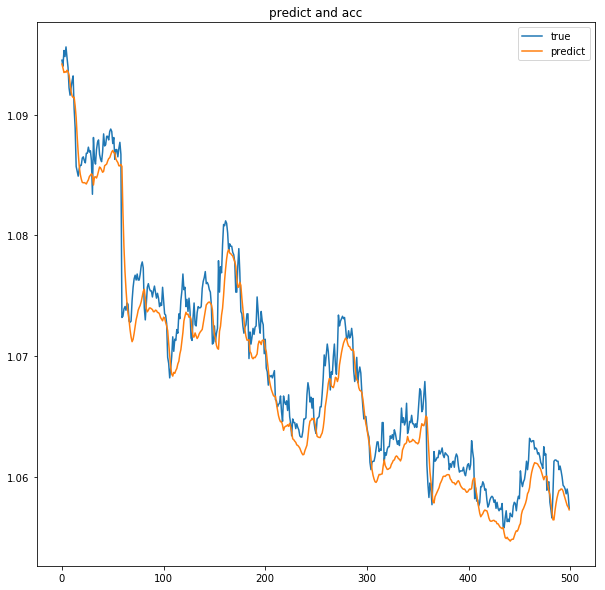

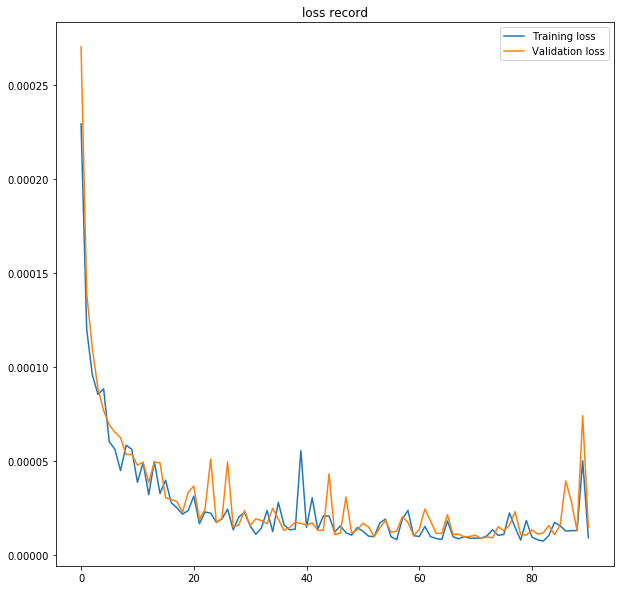

In [113]:
exchange_dnn_mode = dnn_very_deep(seq_length, 1)
exchange_dnn_mode.data_prepare(data_open, seq_length)
exchange_dnn_mode.train(epochs=30)

In [114]:
exchange_dnn_mode.predict(exchange_dnn_mode.x_test[:10])

array([[ 1.09418321],
       [ 1.09385419],
       [ 1.09347761],
       [ 1.09355664],
       [ 1.09349525],
       [ 1.0936693 ],
       [ 1.09355927],
       [ 1.09325993],
       [ 1.09258246],
       [ 1.09190178]], dtype=float32)

## TODO:
**try to save the train relust**

**try to add tensorboard**

**try to add more feature like high, low, close, time**

**try to add normalize layer in the DNN**

**try to predict the price after 5 hours**

**try to predict the trend**

# simple DNN test

In [90]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        #normalised_window = [(p-window.mean())/(window.max() - window.min()) for p in window]
        normalised_window = [100 * ((float(p) - window[0])/window[0]) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def data_prepare(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    mean = data_open.mean()
    interval = data_open.max() - data_open.min()
    data_tmp = [((p - mean)/interval) for p in data_open]
    
    for index in range(len(data_tmp) - sequence_length):
        result.append(data_tmp[index: index + sequence_length])
    
    #if normalise_window:
     #   result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))  

    return [x_train, y_train, x_test, y_test, mean, interval]

In [91]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        self.activation_function = lambda x : 1/(1+np.exp(-x))
    
    def train(self, inputs, targets):
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs.T)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        output_errors = targets.T - final_outputs# Output layer error is the difference between desired target and actual output.
        
        # Backpropagated error
        hidden_errors = np.dot(self.weights_hidden_to_output.T, output_errors) # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs)# hidden layer gradients
        
        # Update the weights
        self.weights_hidden_to_output += self.lr * np.dot(output_errors, hidden_outputs.T)/(inputs.shape[0])# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors * hidden_grad, inputs) / (inputs.shape[0])# update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs):
        #### Implement the forward pass here ####
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs.T)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)# signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)# signals into final output layer
        final_outputs = final_inputs# signals from final output layer 
        
        return final_outputs

In [92]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [93]:
x_train, y_train, x_test, y_test, data_mean, data_interval =  data_prepare(data_open, 100, True)

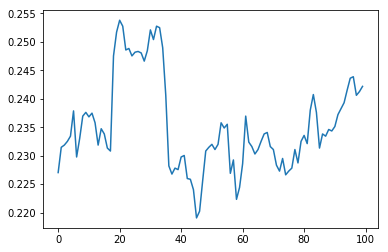

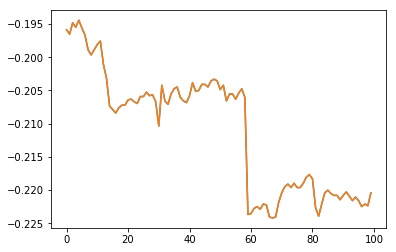

In [94]:
plt.plot(x_train[100])
plt.show()
plt.plot(x_test[100])
plt.plot(y_test[0:100])
plt.show()

In [96]:
import sys

### Set the hyperparameters here ###
epochs = 10
learning_rate = 0.01
hidden_nodes = 300
output_nodes = 1
batch_size = 256
show_every_n_batches = 100

x_train_num = int(x_train.shape[0]*0.9)
x_val_num = x_train.shape[0] - x_train_num

N_i = x_train.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

step = 0
losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    for index in range(0, x_train_num, batch_size):
        step = step+1
        network.train(x_train[index:index+batch_size, :], y_train[index:index+batch_size])
        
        # Printing out the training progress
        if step%show_every_n_batches == 0 :
            train_loss = MSE(network.run(x_train[:x_train_num, :]), y_train[:x_train_num])
            val_loss = MSE(network.run(x_train[x_train_num:, :]), y_train[x_train_num:])
            sys.stdout.write("\rProgress: " + str(100 * step/(float(epochs)*(x_train_num/batch_size)))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:15] \
                     + " ... Validation loss: " + str(val_loss)[:15])
    
            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)

Progress: 98.5% ... Training loss: 8.4705360114e-0 ... Validation loss: 8.55042774856e-

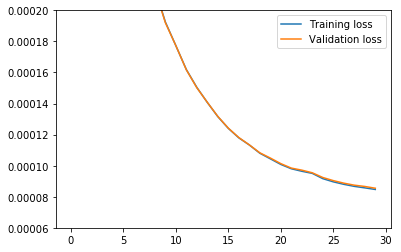

In [97]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.show()

In [98]:
test_pre = network.run(x_test[:500])

In [99]:
test_pre.shape

(1, 500)

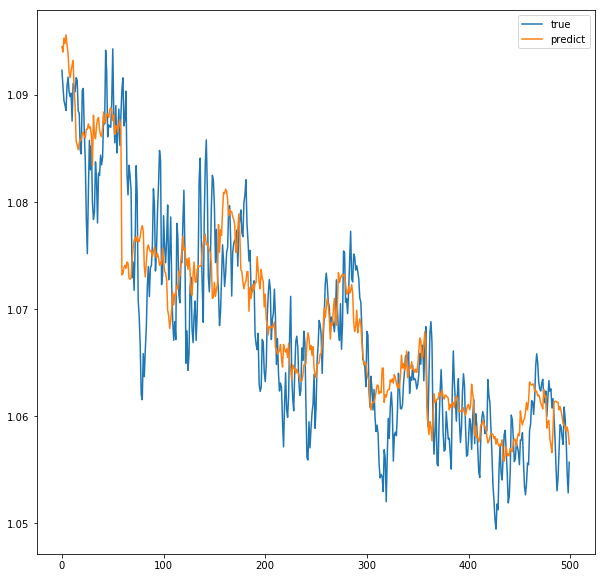

In [100]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(test_pre[0, :]*data_interval+data_mean, label='true')
plt.plot(y_test[:500]*data_interval+data_mean, label='predict')
plt.legend()
plt.show()